# Libraries

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from spacy import displacy, tokenizer
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import gensim
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import LsiModel, LdaModel
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, classification_report

In [29]:
# set plot settings
plt.rcParams['figure.figsize'] = (12,8)
default_plot_color = '#00bfbf'

# Import and Analysing the dataset

In [37]:
data = pd.read_csv('Datasets/fake_news_data.csv')
data.head()

,title,text,date,fake_or_factual
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News


Text(0.5, 1.0, 'Count of Article classification')

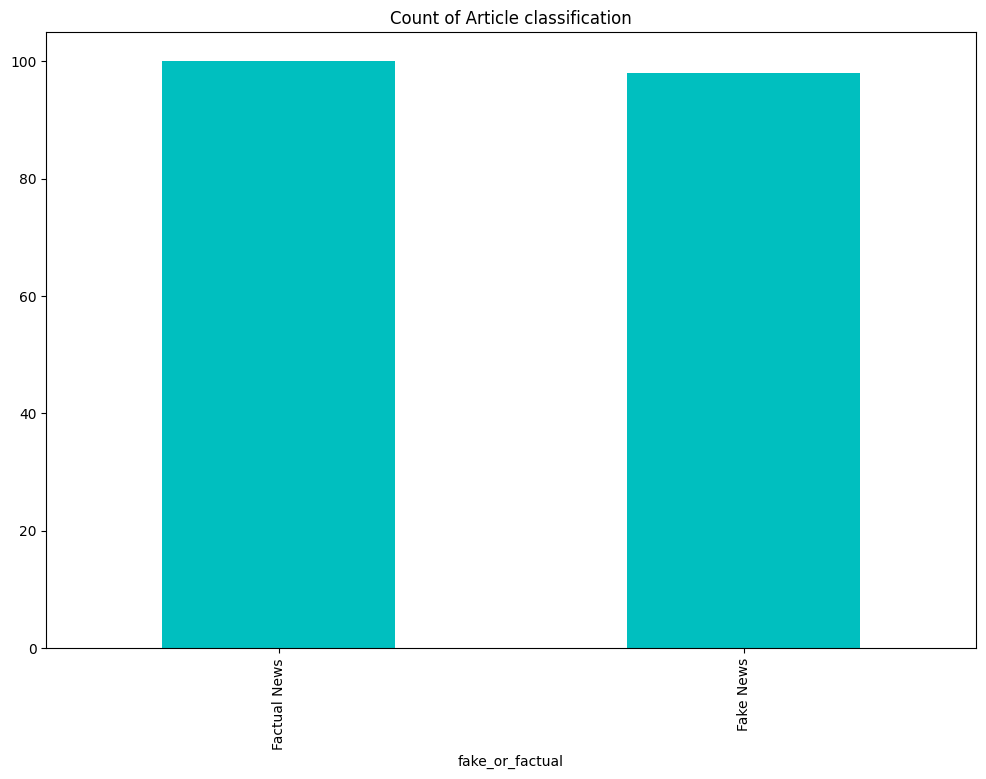

In [38]:
data['fake_or_factual'].value_counts().plot(kind='bar', color=default_plot_color)
plt.title('Count of Article classification')

# POS Tagging

In [5]:
nlp = spacy.load('en_core_web_sm')

In [6]:
fake_news = data[data['fake_or_factual'] == 'Fake News']
fact_news = data[data['fake_or_factual'] == 'Factual News']

In [7]:
fake_spacyDoc = list(nlp.pipe(fake_news['text']))
fact_spacyDoc = list(nlp.pipe(fact_news['text']))

In [8]:
def extract_token_tags(doc:spacy.tokens.doc.Doc):
    return [(i.text, i.ent_type_, i.pos_) for i in doc]

In [9]:
fake_tagdf = []
columns = ['tokens', 'ner_tag', 'pos_tag']

In [10]:
for ix, doc in enumerate(fake_spacyDoc):
    tags = extract_token_tags(doc)
    tags = pd.DataFrame(tags)
    tags.columns = columns
    fake_tagdf.append(tags)

In [11]:
fake_tagdf = pd.concat(fake_tagdf)
fake_tagdf

,tokens,ner_tag,pos_tag
0,There,,PRON
1,are,,VERB
2,two,CARDINAL,NUM
3,small,,ADJ
4,problems,,NOUN
...,...,...,...
743,.,,PUNCT
744,Via,,NOUN
745,:,,PUNCT
746,Campus,,PROPN


In [12]:
fact_tagdf = []
for ix, doc in enumerate(fact_spacyDoc):
    tags = extract_token_tags(doc)
    tags = pd.DataFrame(tags)
    tags.columns = columns
    fact_tagdf.append(tags)

In [13]:
fact_tagdf = pd.concat(fact_tagdf)
fact_tagdf

,tokens,ner_tag,pos_tag
0,WASHINGTON,GPE,PROPN
1,(,,PUNCT
2,Reuters,ORG,PROPN
3,),,PUNCT
4,-,,PUNCT
...,...,...,...
85,citing,,VERB
86,three,CARDINAL,NUM
87,unnamed,,ADJ
88,officials,,NOUN


In [14]:
pos_tag_fake = fake_tagdf.groupby(['tokens', 'pos_tag']).size().reset_index(name='Counts').sort_values(by='Counts', ascending=False)
pos_tag_fake.head(10)

,tokens,pos_tag,Counts
28,",",PUNCT,1908
7446,the,DET,1834
39,.,PUNCT,1531
5759,of,ADP,922
2661,and,CCONJ,875
2446,a,DET,804
0,,SPACE,795
7523,to,PART,767
4915,in,ADP,667
5094,is,AUX,419


In [15]:
pos_tag_fact = fact_tagdf.groupby(['tokens', 'pos_tag']).size().reset_index(name='Counts').sort_values(by='Counts', ascending=False)
pos_tag_fact.head(10)

,tokens,pos_tag,Counts
6169,the,DET,1903
15,",",PUNCT,1698
22,.,PUNCT,1381
4733,of,ADP,884
1905,a,DET,789
2100,and,CCONJ,757
4015,in,ADP,672
6230,to,PART,660
4761,on,ADP,482
5586,said,VERB,452


In [16]:
pos_tag_fake.groupby('pos_tag')['tokens'].count().sort_values(ascending=False).head(10)

pos_tag
NOUN     2597
VERB     1814
PROPN    1657
ADJ       876
ADV       412
NUM       221
PRON       99
ADP        88
AUX        58
SCONJ      54
Name: tokens, dtype: int64

In [17]:
pos_tag_fact.groupby('pos_tag')['tokens'].count().sort_values(ascending=False).head(10)

pos_tag
NOUN     2182
VERB     1535
PROPN    1387
ADJ       753
ADV       271
NUM       203
PRON       81
ADP        70
AUX        44
SCONJ      39
Name: tokens, dtype: int64

In [18]:
pos_tag_fake[pos_tag_fake['pos_tag'] == 'NOUN'][:15]

,tokens,pos_tag,Counts
5969,people,NOUN,77
7959,women,NOUN,55
6204,president,NOUN,53
7511,time,NOUN,52
8011,year,NOUN,44
3134,campaign,NOUN,44
4577,government,NOUN,41
5208,law,NOUN,40
7344,t,NOUN,40
8013,years,NOUN,40


In [19]:
pos_tag_fact[pos_tag_fact['pos_tag'] == 'NOUN'][:15]

,tokens,pos_tag,Counts
3748,government,NOUN,71
6639,year,NOUN,64
5927,state,NOUN,58
2373,bill,NOUN,55
1982,administration,NOUN,51
3289,election,NOUN,48
5084,president,NOUN,47
4804,order,NOUN,45
4937,people,NOUN,45
2509,campaign,NOUN,42


# Named Entity Recognition    

In [20]:
fake_ner = fake_tagdf[fake_tagdf['ner_tag'] != ''].groupby(['tokens','ner_tag']).size().reset_index(name='Counts').sort_values(by='Counts', ascending=False)
fake_ner.head(10)

,tokens,ner_tag,Counts
1723,Trump,ORG,227
578,Clinton,PERSON,118
2097,the,ORG,113
1724,Trump,PERSON,91
697,Donald,PERSON,74
877,Hillary,PERSON,63
1174,McCain,PERSON,53
2038,one,CARDINAL,44
2139,year,DATE,43
1482,Republican,NORP,42


In [21]:
fact_ner = fact_tagdf[fact_tagdf['ner_tag'] != ''].groupby(['tokens','ner_tag']).size().reset_index(name='Counts').sort_values(by='Counts', ascending=False)
fact_ner.head(10)

,tokens,ner_tag,Counts
1624,Trump,ORG,195
1986,the,ORG,154
1645,U.S.,GPE,138
1383,Reuters,ORG,131
880,House,ORG,68
1625,Trump,PERSON,63
2013,year,DATE,61
1661,United,GPE,60
1983,the,GPE,60
1544,States,GPE,56


In [22]:
# create custom palette to ensure plots are consistent
ner_palette = {
    'ORG': sns.color_palette("Set2").as_hex()[0],
    'GPE': sns.color_palette("Set2").as_hex()[1],
    'NORP': sns.color_palette("Set2").as_hex()[2],
    'PERSON': sns.color_palette("Set2").as_hex()[3],
    'DATE': sns.color_palette("Set2").as_hex()[4],
    'CARDINAL': sns.color_palette("Set2").as_hex()[5],
    'PERCENT': sns.color_palette("Set2").as_hex()[6]
}

[Text(0.5, 1.0, 'Named Entity in Fake News')]

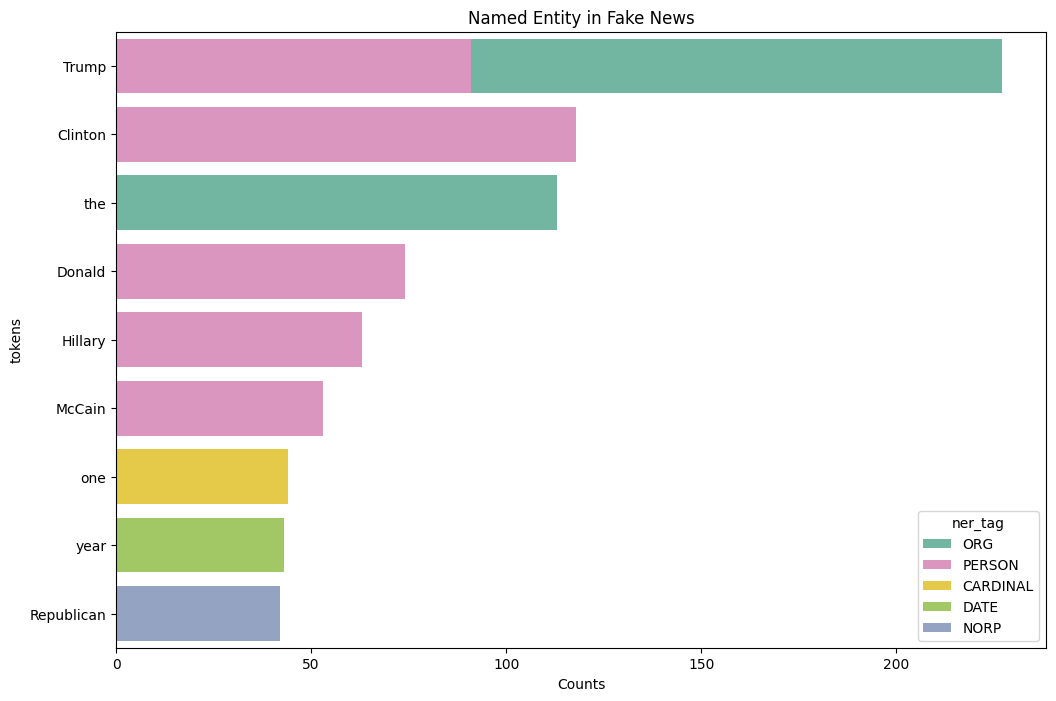

In [23]:
sns.barplot(
    x='Counts',
    y='tokens',
    hue='ner_tag',
    palette=ner_palette,
    data=fake_ner[:10],
    orient='h',
    dodge=False
).set(title = 'Named Entity in Fake News')

[Text(0.5, 1.0, 'Named Entity in Factual News')]

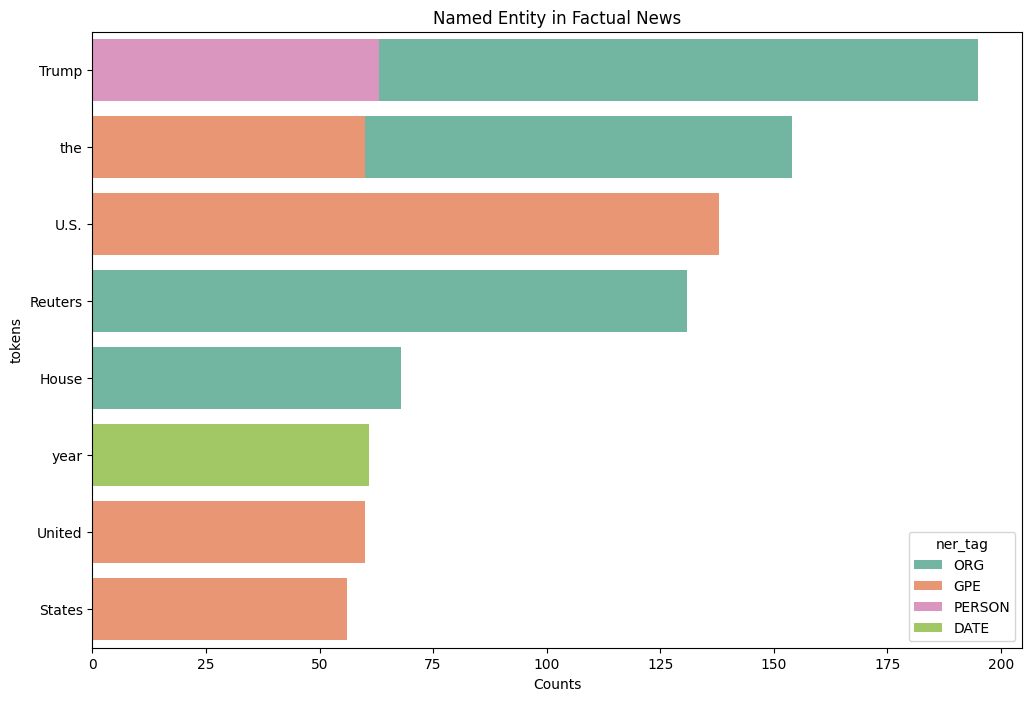

In [24]:
sns.barplot(
    x='Counts',
    y='tokens',
    hue='ner_tag',
    palette=ner_palette,
    data=fact_ner[:10],
    orient='h',
    dodge=False
).set(title = 'Named Entity in Factual News')

# Text Preprocessing

In [39]:
data.head()

,title,text,date,fake_or_factual
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News


In [40]:
# Remoing text before hiphen (-)
data['text_cleaned'] = data['text'].apply(lambda x: re.sub(r"^.*?-", '', x))

# Converting into lower case
data['text_cleaned'] = data['text_cleaned'].str.lower()

# removing panctuation marks
data['text_cleaned'] = data['text_cleaned'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

# Removing stopwords
en_stopwords = stopwords.words('english')
data['text_cleaned'] = data['text_cleaned'].apply(lambda text: ' '.join([word for word in text.split() if word not in en_stopwords]))

# Tokanization
data['text_cleaned'] = data['text_cleaned'].apply(lambda text: word_tokenize(text))

# Lemmatization
lemmatize = WordNetLemmatizer()
data['text_cleaned'] = data['text_cleaned'].apply(lambda list: [lemmatize.lemmatize(word) for word in list])

data.head()

,title,text,date,fake_or_factual,text_cleaned
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[yearold, oscarwinning, actress, described, me..."
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,..."
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u..."
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon..."
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,..."


In [42]:
token_clean = sum(data['text_cleaned'], [])
print(token_clean)

['yearold', 'oscarwinning', 'actress', 'described', 'meeting', '16yearold', 'girl', 'apparently', 'given', 'birth', 'shortly', 'arriving', 'island', 'smile', 'approach', 'without', 'translator', 'conversation', 'basicfriendly', 'sarandon', 'wrote', 'experience', 'take', 'bundle', 'next', 'open', 'inside', 'perfect', 'rosy', 'newborn', 'actress', 'continuesshe', 'beaming', 'proud', 'young', 'girl', 'given', 'birth', 'manage', 'trip', 'sea', 'walking', 'give', 'birthwasn', 'mary', 'kid', 'joseph', 'took', 'road', 'far', 'manger', 'syrian', 'baby', 'room', 'innsarandon', 'short', 'column', 'part', 'new', 'collaborative', 'series', 'huffington', 'post', 'virtual', 'reality', 'network', 'ryot', 'called', 'crossing', 'see', 'actress', 'host', 'series', 'report', 'chronicling', 'refugee', 'crisis', 'unfolds', 'greece', 'actress', 'also', 'criticized', 'political', 'discourse', 'surrounding', 'refugee', 'crisis', 'united', 'state', 'seemed', 'like', 'people', 'loudest', 'voice', 'xenophobic', 

In [45]:
unigrams = (pd.Series(nltk.ngrams(token_clean, n=1)).value_counts())
print(unigrams)

(said,)         560
(trump,)        520
(u,)            255
(state,)        250
(president,)    226
               ... 
(streak,)         1
(bennewise,)      1
(patsy,)          1
(lakeland,)       1
(petrosyan,)      1
Name: count, Length: 8572, dtype: int64
